In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17851295708342209836
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6602251960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1039672935963787700
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2, _range=None, multichannel=None):
    return compare_ssim(img1, img2, data_range=_range, multichannel=multichannel)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
"""
    custom loss function
"""
"""
def customLoss(layer):
    def loss(y_true, y_pred):
        return keras_backend
    return loss
"""
# Keras lib: https://github.com/keras-team/keras-contrib
# Combine loss: https://stackoverflow.com/questions/51705464/keras-tensorflow-combined-loss-function-for-single-output
# TF example: https://stackoverflow.com/questions/52798540/working-with-ssim-loss-function-in-tensorflow-for-rgb-images
# MSE source: https://github.com/keras-team/keras/blob/master/keras/losses.py
# TF SSIM: https://www.tensorflow.org/api_docs/python/tf/image/ssim
#To-Notice: SSIM on RGB will be average

# Customize loss for multi parameters: https://github.com/keras-team/keras/issues/2121

# keras github mse problem for customize loss layer ( axis=-1)
#https://stackoverflow.com/questions/41707621/keras-mean-squared-error-loss-layer

#tensorflow mse
#https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error

#https://stackoverflow.com/questions/50124158/keras-loss-function-with-additional-dynamic-parameter
"""
https://www.mathworks.com/matlabcentral/answers/231932-is-this-how-to-calculate-mean-square-error-for-two-images
function MSE= MSE(lena, image_new);
[M, N] = size(lena);
error = lena - (image_new);
MSE = sum(sum(error .* error)) / (M * N);
disp(MSE);
end
"""

import keras.backend as K

def testMSE(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def MSE_Plus_SSIM(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1) + DSSIMObjective(y_true, y_pred)
    return (1.0 - tf.image.ssim(y_pred, y_true, 1.0)) + K.mean(K.square(y_pred - y_true))

def MSE_Plus_SSIM_Loss(y_true, y_pred, y_true_32, y_true_64, y_true_128, y_true_256, y_pred_32, y_pred_64, y_pred_128, y_pred_256): 
    loss = (
        (1.0 - tf.image.ssim(y_pred, y_true, 1.0))
        + (1.0 - tf.image.ssim(y_pred_32, y_true_32, 1.0))
        + (1.0 - tf.image.ssim(y_pred_64, y_true_64, 1.0))
        + (1.0 - tf.image.ssim(y_pred_128, y_true_128, 1.0))
        + (1.0 - tf.image.ssim(y_pred_256, y_true_256, 1.0))
    )
    
    loss2 = (
        K.mean(K.square(y_pred - y_true))
        + K.mean(K.square(y_pred_32 - y_true_32))
        + K.mean(K.square(y_pred_64 - y_true_64))
        + K.mean(K.square(y_pred_128 - y_true_128))
        + K.mean(K.square(y_pred_256 - y_true_256))
    )
    
    """
    loss = (
        (1.0 - tf.image.ssim(y_pred, y_true, 1.0)) + K.mean(K.square(y_pred - y_true), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_16, y_true_16, 1.0)) + K.mean(K.square(y_pred_16 - y_true_16), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_32, y_true_32, 1.0)) + K.mean(K.square(y_pred_32 - y_true_32), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_64, y_true_64, 1.0)) + K.mean(K.square(y_pred_64 - y_true_64), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_128, y_true_128, 1.0)) + K.mean(K.square(y_pred_128 - y_true_128), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_256, y_true_256, 1.0)) + K.mean(K.square(y_pred_256 - y_true_256), axis=-1)
    )"""
    return loss + loss2

In [3]:





"""
    resNet50 model
    loading weight 
"""
import os
import warnings
from keras import layers as Layers
from keras import models as Models
from keras import utils as Utils
from keras_applications import imagenet_utils as utils

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

def get_submodules_from_kwargs(kwargs):
    backend = keras_backend
    layers = Layers
    models = Models
    utils = Utils
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape =  utils._obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x1 = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x1)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x2 = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x2, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x3 = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x3, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, [x, x1, x2, x3], name='resnet50')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path, by_name=True)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)    
        
    return model

In [4]:
model = ResNet50(input_shape=(512,512, 3), include_top=False)
model.trainable = False


model.compile(loss="mse",
                  optimizer=Adam(),
                  metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\tomsan\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:244: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
"""
    resNet as backbone with simple CNN model
"""
def resNet50asBackbone(pretrained_weights=None):
    x_input = Input(shape=(512, 512, 3), name='image_in')
    
    x_32, x1, x2, x3 = model(x_input) #32 64 128 256 512
   
    #x = Conv2D(128, (3, 3), activation='relu',padding="same")(x)
    x_64 = UpSampling2D()(x_32) #1024
    x_128 = UpSampling2D()(x_64)
    x_128 = Conv2D(128, (1, 2), activation='relu',padding="same")(x_128)
    x_256 = UpSampling2D()(x_128)
    x_512 = UpSampling2D()(x_256)
    
    #x1_256 = Conv2D(128, (3, 3), activation='relu', padding="same")(x1)
    x1_512 = UpSampling2D()(x1)
    
    x2_256 = UpSampling2D()(x2)
    x2_512 = UpSampling2D()(x2_256)
    x2_512 = Conv2D(128, (1, 2), activation='relu',padding="same")(x2_512)
    
    x3_128 = UpSampling2D()(x3)
    x3_256 = UpSampling2D()(x3_128)
    x3_256 = Conv2D(128, (1, 2), activation='relu',padding="same")(x3_256)
    x3_512 = UpSampling2D()(x3_256)
    
    y_pred = Concatenate()([x_input, x_512, x1_512, x2_512, x3_512])
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(3, (1, 1), activation='relu', padding="same")(y_pred)
    
    resNet50model = Model(inputs=x_input, outputs=y_pred)
    resNet50model.compile(loss="mse",
                  optimizer=Adam(),
                  metrics=['accuracy'])
    if(pretrained_weights):
        resNet50model.load_weights(pretrained_weights)
    return resNet50model
#https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer


In [6]:
"""
    load training data
"""
import gc

dataY = np.zeros((4000,512, 512, 3))

count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray/" + picture + ".png")
    dataY[count] = img
    dataY[count+1] = img
    dataY[count+2] = img
    dataY[count+3] = img
    dataY[count+4] = img
    count += 5
                 
dataY = dataY.reshape(-1, 512, 512, 3)
dataY = dataY.astype('float32') / 255

In [7]:
"""
    noise image
"""
X = np.zeros((4000,512, 512, 3))
count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out50.png")
    X[count] = img
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out60.png")
    X[count+1] = img
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out70.png")
    X[count+2] = img
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out80.png")
    X[count+3] = img
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out90.png")
    X[count+4] = img
    count += 5

X = X.reshape(-1, 512, 512, 3)
X = X.astype('float32') / 255
                 
#X_train, X_test, y_train, y_test = train_test_split(X, dataY, test_size=0.3, random_state=41)

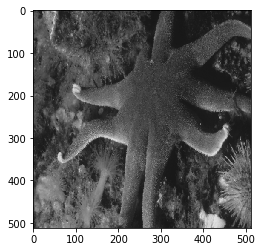

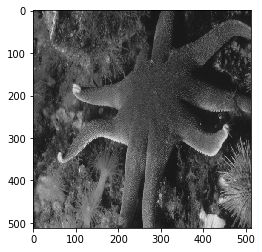

30.315876007080078


In [8]:
X_train = X.reshape(-1, 512, 512, 3)
y_train = dataY.reshape(-1, 512, 512, 3)
img = X_train[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], X_train[1]) )

In [81]:
resNet50 = resNet50asBackbone()
print(resNet50.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                [(None, 32, 32, 1024 8589184     image_in[0][0]                   
__________________________________________________________________________________________________
up_sampling2d_116 (UpSampling2D (None, 64, 64, 1024) 0           resnet50[4][0]                   
__________________________________________________________________________________________________
up_sampling2d_117 (UpSampling2D (None, 128, 128, 102 0           up_sampling2d_116[0][0]          
__________________________________________________________________________________________________
up_samplin

In [82]:
modelCheck = ModelCheckpoint('backbone_afterGauss_v2_{epoch:04d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
history = History()

resNet50.fit(X, dataY,
            batch_size=1,
            epochs=50,
            verbose=1,
            validation_split=0.3,
            callbacks=[modelCheck, history])
#0.0018
#0.2404

Train on 2800 samples, validate on 1200 samples
Epoch 1/50
2800/2800 [==============================] - 547s 195ms/step - loss: 0.2288 - acc: 0.7200 - val_loss: 0.1787 - val_acc: 0.0000e+00
Epoch 2/50
2800/2800 [==============================] - 523s 187ms/step - loss: 0.1772 - acc: 4.8537e-05 - val_loss: 0.1786 - val_acc: 0.0000e+00
Epoch 3/50
2800/2800 [==============================] - 523s 187ms/step - loss: 0.1210 - acc: 0.1924 - val_loss: 0.0493 - val_acc: 0.0000e+00
Epoch 4/50
2800/2800 [==============================] - 523s 187ms/step - loss: 0.0349 - acc: 0.3435 - val_loss: 0.0350 - val_acc: 0.4196
Epoch 5/50
2800/2800 [==============================] - 551s 197ms/step - loss: 0.0063 - acc: 0.4309 - val_loss: 0.0034 - val_acc: 0.2792
Epoch 6/50
2800/2800 [==============================] - 645s 231ms/step - loss: 0.0029 - acc: 0.4025 - val_loss: 0.0030 - val_acc: 0.1760
Epoch 7/50
2800/2800 [==============================] - 644s 230ms/step - loss: 0.0027 - acc: 0.3638 - val_l

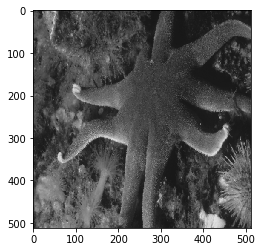

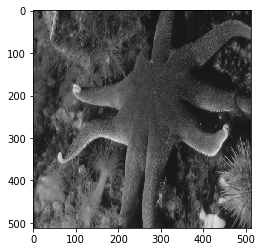

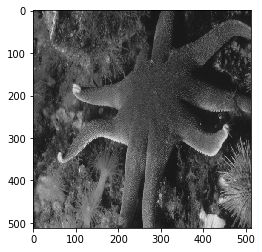

30.315876007080078
30.193989276885986
28.198599393069745
28.295033091902734
0.855602974108745
0.8556305774987164


In [83]:
result = resNet50.predict(X,  batch_size=1)
X_train = X
y_train = dataY
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], X_train[1]) )
print(PSNR(y_train[1], result[1]) )

totalPSNR = 0
for i in range(4000):
    totalPSNR += PSNR(y_train[i], X_train[i])
#print(totalPSNR)
print(totalPSNR / 4000)

totalPSNR = 0
for i in range(4000):
    totalPSNR += PSNR(y_train[i], result[i])
#print(totalPSNR)
print(totalPSNR / 4000)

totalSSIM = 0
for i in range(4000):
    totalSSIM += SSIM(y_train[i], X_train[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 4000)

totalSSIM = 0
for i in range(4000):
    totalSSIM += SSIM(y_train[i], result[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 4000)


In [84]:
resNet50 = resNet50asBackbone("backbone_afterGauss_v2_0043.h5")
modelCheck = ModelCheckpoint('backbone_afterGauss_v2_0043_{epoch:04d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
history = History()

resNet50.fit(X, dataY,
            batch_size=1,
            epochs=157,
            verbose=1,
            validation_split=0.3,
            callbacks=[modelCheck, history])
#0.0018
#0.2404

Train on 2800 samples, validate on 1200 samples
Epoch 1/157
2800/2800 [==============================] - 545s 195ms/step - loss: 0.0020 - acc: 0.3658 - val_loss: 0.0023 - val_acc: 0.0333
Epoch 2/157
2800/2800 [==============================] - 525s 188ms/step - loss: 0.0020 - acc: 0.3717 - val_loss: 0.0021 - val_acc: 0.3613
Epoch 3/157
2800/2800 [==============================] - 525s 187ms/step - loss: 0.0020 - acc: 0.3658 - val_loss: 0.0021 - val_acc: 0.3648
Epoch 4/157
2800/2800 [==============================] - 525s 187ms/step - loss: 0.0020 - acc: 0.3771 - val_loss: 0.0021 - val_acc: 0.4000
Epoch 5/157
2800/2800 [==============================] - 525s 187ms/step - loss: 0.0021 - acc: 0.3927 - val_loss: 0.0024 - val_acc: 0.9401
Epoch 6/157
2800/2800 [==============================] - 525s 187ms/step - loss: 0.0020 - acc: 0.4269 - val_loss: 0.0021 - val_acc: 0.3463
Epoch 7/157
2800/2800 [==============================] - 525s 187ms/step - loss: 0.0020 - acc: 0.4302 - val_loss: 0.00

2800/2800 [==============================] - 538s 192ms/step - loss: 0.0019 - acc: 0.6890 - val_loss: 0.0021 - val_acc: 0.4586
Epoch 118/157
2800/2800 [==============================] - 538s 192ms/step - loss: 0.0019 - acc: 0.6542 - val_loss: 0.0020 - val_acc: 0.7725
Epoch 119/157
2800/2800 [==============================] - 535s 191ms/step - loss: 0.0019 - acc: 0.6901 - val_loss: 0.0021 - val_acc: 0.7470
Epoch 120/157
2800/2800 [==============================] - 532s 190ms/step - loss: 0.0019 - acc: 0.6793 - val_loss: 0.0020 - val_acc: 0.9780
Epoch 121/157
2800/2800 [==============================] - 534s 191ms/step - loss: 0.0019 - acc: 0.7290 - val_loss: 0.0020 - val_acc: 0.1203
Epoch 122/157
2800/2800 [==============================] - 532s 190ms/step - loss: 0.0019 - acc: 0.7521 - val_loss: 0.0020 - val_acc: 0.3969
Epoch 123/157
2800/2800 [==============================] - 533s 191ms/step - loss: 0.0019 - acc: 0.6635 - val_loss: 0.0020 - val_acc: 0.9367
Epoch 124/157
2800/2800 [==

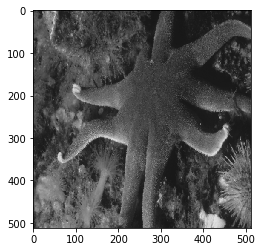

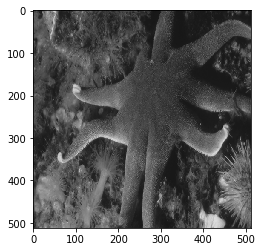

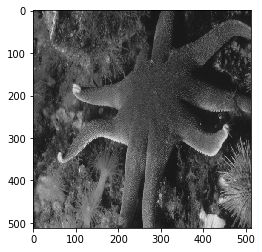

30.315876007080078
30.541653633117676
28.198599393069745
28.571641942560674
0.855602974108745
0.8604892684415215


In [85]:
result = resNet50.predict(X,  batch_size=1)
X_train = X
y_train = dataY
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], X_train[1]) )
print(PSNR(y_train[1], result[1]) )

totalPSNR = 0
for i in range(4000):
    totalPSNR += PSNR(y_train[i], X_train[i])
#print(totalPSNR)
print(totalPSNR / 4000)

totalPSNR = 0
for i in range(4000):
    totalPSNR += PSNR(y_train[i], result[i])
#print(totalPSNR)
print(totalPSNR / 4000)

totalSSIM = 0
for i in range(4000):
    totalSSIM += SSIM(y_train[i], X_train[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 4000)

totalSSIM = 0
for i in range(4000):
    totalSSIM += SSIM(y_train[i], result[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 4000)

In [14]:
"""
    resNet as backbone with simple CNN model
"""
def resNet50asBackbone_return(pretrained_weights=None):
    x_input = Input(shape=(512, 512, 3), name='image_in')
    
    x_32, x1, x2, x3 = model(x_input) #32 64 128 256 512
   
    #x = Conv2D(128, (3, 3), activation='relu',padding="same")(x)
    x_64 = UpSampling2D()(x_32) #1024
    x_128 = UpSampling2D()(x_64)
    x_128 = Conv2D(128, (1, 2), activation='relu',padding="same")(x_128)
    x_256 = UpSampling2D()(x_128)
    x_512 = UpSampling2D()(x_256)
    
    #x1_256 = Conv2D(128, (3, 3), activation='relu', padding="same")(x1)
    x1_512 = UpSampling2D()(x1)
    
    x2_256 = UpSampling2D()(x2)
    x2_512 = UpSampling2D()(x2_256)
    x2_512 = Conv2D(128, (1, 2), activation='relu',padding="same")(x2_512)
    
    x3_128 = UpSampling2D()(x3)
    x3_256 = UpSampling2D()(x3_128)
    x3_256 = Conv2D(128, (1, 2), activation='relu',padding="same")(x3_256)
    x3_512 = UpSampling2D()(x3_256)
    
    y_pred = Concatenate()([x_input, x_512, x1_512, x2_512, x3_512])
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(3, (1, 1), activation='relu', padding="same")(y_pred)
    
    resNet50model = Model(inputs=x_input, outputs=y_pred)
    resNet50model.compile(loss="mse",
                  optimizer=Adam(),
                  metrics=['accuracy'])
    if(pretrained_weights):
        resNet50model.load_weights(pretrained_weights)
    return resNet50model
#https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer


In [15]:
resNet50 = resNet50asBackbone_return("backbone_afterGauss_v2_0043_0148.h5")
modelCheck = ModelCheckpoint('backbone_afterGauss_v2_0148_{epoch:04d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
history = History()

resNet50.fit(X, dataY,
            batch_size=1,
            epochs=352,
            verbose=1,
            validation_split=0.3,
            callbacks=[modelCheck, history])
#0.0018
#0.2404

Instructions for updating:
Use tf.cast instead.
Train on 2800 samples, validate on 1200 samples
Epoch 1/352
2800/2800 [==============================] - 477s 170ms/step - loss: 0.0019 - acc: 0.6724 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2/352
2800/2800 [==============================] - 466s 166ms/step - loss: 0.0019 - acc: 0.7030 - val_loss: 0.0020 - val_acc: 0.3790
Epoch 3/352
2800/2800 [==============================] - 466s 166ms/step - loss: 0.0019 - acc: 0.6988 - val_loss: 0.0020 - val_acc: 0.7734
Epoch 4/352
2800/2800 [==============================] - 466s 166ms/step - loss: 0.0019 - acc: 0.6746 - val_loss: 0.0020 - val_acc: 0.9620
Epoch 5/352
2800/2800 [==============================] - 466s 166ms/step - loss: 0.0019 - acc: 0.6748 - val_loss: 0.0020 - val_acc: 0.4318
Epoch 6/352
2800/2800 [==============================] - 465s 166ms/step - loss: 0.0019 - acc: 0.6775 - val_loss: 0.0020 - val_acc: 0.1707
Epoch 7/352
2800/2800 [==============================] - 465s 166ms/st

2800/2800 [==============================] - 481s 172ms/step - loss: 0.0019 - acc: 0.6137 - val_loss: 0.0020 - val_acc: 0.4552
Epoch 58/352
2800/2800 [==============================] - 480s 172ms/step - loss: 0.0019 - acc: 0.6707 - val_loss: 0.0020 - val_acc: 0.9996
Epoch 59/352
2800/2800 [==============================] - 469s 167ms/step - loss: 0.0019 - acc: 0.6935 - val_loss: 0.0020 - val_acc: 0.0887
Epoch 60/352
2800/2800 [==============================] - 482s 172ms/step - loss: 0.0019 - acc: 0.6300 - val_loss: 0.0020 - val_acc: 0.8944
Epoch 61/352
2800/2800 [==============================] - 486s 174ms/step - loss: 0.0019 - acc: 0.6411 - val_loss: 0.0020 - val_acc: 0.4061
Epoch 62/352
2800/2800 [==============================] - 486s 174ms/step - loss: 0.0019 - acc: 0.6141 - val_loss: 0.0021 - val_acc: 0.4072
Epoch 63/352
2800/2800 [==============================] - 484s 173ms/step - loss: 0.0019 - acc: 0.6462 - val_loss: 0.0020 - val_acc: 0.3893
Epoch 64/352
2800/2800 [=========

2800/2800 [==============================] - 514s 184ms/step - loss: 0.0019 - acc: 0.6466 - val_loss: 0.0020 - val_acc: 0.8850
Epoch 116/352
2800/2800 [==============================] - 536s 191ms/step - loss: 0.0019 - acc: 0.6794 - val_loss: 0.0020 - val_acc: 0.3943
Epoch 117/352
2800/2800 [==============================] - 554s 198ms/step - loss: 0.0019 - acc: 0.6231 - val_loss: 0.0020 - val_acc: 0.9987
Epoch 118/352
2800/2800 [==============================] - 583s 208ms/step - loss: 0.0019 - acc: 0.6489 - val_loss: 0.0020 - val_acc: 0.4114
Epoch 119/352
2800/2800 [==============================] - 600s 214ms/step - loss: 0.0019 - acc: 0.6258 - val_loss: 0.0020 - val_acc: 0.4387
Epoch 120/352
2800/2800 [==============================] - 609s 217ms/step - loss: 0.0019 - acc: 0.7104 - val_loss: 0.0020 - val_acc: 0.9877
Epoch 121/352
2800/2800 [==============================] - 593s 212ms/step - loss: 0.0019 - acc: 0.7519 - val_loss: 0.0020 - val_acc: 0.1019
Epoch 122/352
2800/2800 [==

2800/2800 [==============================] - 459s 164ms/step - loss: 0.0019 - acc: 0.6347 - val_loss: 0.0020 - val_acc: 0.9972
Epoch 174/352
2800/2800 [==============================] - 460s 164ms/step - loss: 0.0019 - acc: 0.6941 - val_loss: 0.0020 - val_acc: 0.0531
Epoch 175/352
2800/2800 [==============================] - 460s 164ms/step - loss: 0.0019 - acc: 0.7059 - val_loss: 0.0020 - val_acc: 0.9669
Epoch 176/352
2800/2800 [==============================] - 460s 164ms/step - loss: 0.0019 - acc: 0.7594 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 177/352
2800/2800 [==============================] - 460s 164ms/step - loss: 0.0019 - acc: 0.7291 - val_loss: 0.0020 - val_acc: 0.3377
Epoch 178/352
2800/2800 [==============================] - 460s 164ms/step - loss: 0.0019 - acc: 0.6794 - val_loss: 0.0020 - val_acc: 0.9934
Epoch 179/352
2800/2800 [==============================] - 460s 164ms/step - loss: 0.0019 - acc: 0.6826 - val_loss: 0.0020 - val_acc: 0.3905
Epoch 180/352
2800/2800 [==

2800/2800 [==============================] - 451s 161ms/step - loss: 0.0019 - acc: 0.7550 - val_loss: 0.0020 - val_acc: 0.9144
Epoch 232/352
2800/2800 [==============================] - 451s 161ms/step - loss: 0.0019 - acc: 0.7274 - val_loss: 0.0020 - val_acc: 0.6594
Epoch 233/352
2800/2800 [==============================] - 451s 161ms/step - loss: 0.0019 - acc: 0.7409 - val_loss: 0.0020 - val_acc: 0.9792
Epoch 234/352
2800/2800 [==============================] - 451s 161ms/step - loss: 0.0019 - acc: 0.7058 - val_loss: 0.0020 - val_acc: 0.6573
Epoch 235/352
2800/2800 [==============================] - 450s 161ms/step - loss: 0.0019 - acc: 0.7043 - val_loss: 0.0020 - val_acc: 0.9687
Epoch 236/352
2800/2800 [==============================] - 450s 161ms/step - loss: 0.0019 - acc: 0.6432 - val_loss: 0.0020 - val_acc: 0.9532
Epoch 237/352
2800/2800 [==============================] - 449s 160ms/step - loss: 0.0019 - acc: 0.7363 - val_loss: 0.0020 - val_acc: 0.7746
Epoch 238/352
2800/2800 [==

2800/2800 [==============================] - 453s 162ms/step - loss: 0.0019 - acc: 0.6730 - val_loss: 0.0020 - val_acc: 0.4770
Epoch 290/352
2800/2800 [==============================] - 454s 162ms/step - loss: 0.0019 - acc: 0.6412 - val_loss: 0.0020 - val_acc: 0.9810
Epoch 291/352
2800/2800 [==============================] - 453s 162ms/step - loss: 0.0019 - acc: 0.6437 - val_loss: 0.0021 - val_acc: 0.9843
Epoch 292/352
2800/2800 [==============================] - 448s 160ms/step - loss: 0.0019 - acc: 0.6513 - val_loss: 0.0020 - val_acc: 0.3941
Epoch 293/352
2800/2800 [==============================] - 450s 161ms/step - loss: 0.0019 - acc: 0.7124 - val_loss: 0.0020 - val_acc: 0.3814
Epoch 294/352
2800/2800 [==============================] - 451s 161ms/step - loss: 0.0019 - acc: 0.7332 - val_loss: 0.0020 - val_acc: 0.9892
Epoch 295/352
2800/2800 [==============================] - 451s 161ms/step - loss: 0.0019 - acc: 0.7765 - val_loss: 0.0020 - val_acc: 0.3051
Epoch 296/352
2800/2800 [==

2800/2800 [==============================] - 487s 174ms/step - loss: 0.0019 - acc: 0.7619 - val_loss: 0.0021 - val_acc: 0.2549
Epoch 348/352
2800/2800 [==============================] - 487s 174ms/step - loss: 0.0019 - acc: 0.6777 - val_loss: 0.0020 - val_acc: 0.2486
Epoch 349/352
2800/2800 [==============================] - 487s 174ms/step - loss: 0.0019 - acc: 0.7102 - val_loss: 0.0021 - val_acc: 0.7895
Epoch 350/352
2800/2800 [==============================] - 487s 174ms/step - loss: 0.0019 - acc: 0.6960 - val_loss: 0.0020 - val_acc: 0.9146
Epoch 351/352
2800/2800 [==============================] - 487s 174ms/step - loss: 0.0019 - acc: 0.7098 - val_loss: 0.0020 - val_acc: 0.2820
Epoch 352/352
2800/2800 [==============================] - 489s 175ms/step - loss: 0.0019 - acc: 0.8207 - val_loss: 0.0020 - val_acc: 0.9988


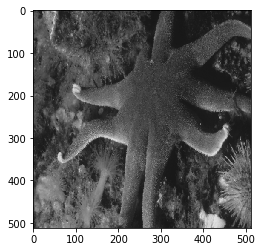

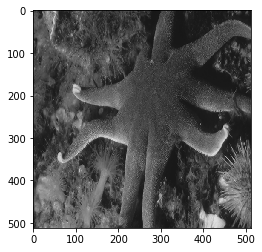

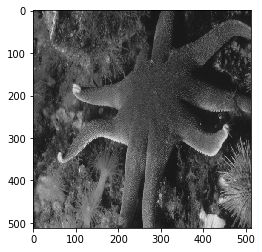

30.315876007080078
30.666470527648926
28.198599393069745
28.781919613182545
0.855602974108745
0.8660171075919204


In [16]:
result = resNet50.predict(X,  batch_size=1)
X_train = X
y_train = dataY
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], X_train[1]) )
print(PSNR(y_train[1], result[1]) )

totalPSNR = 0
for i in range(4000):
    totalPSNR += PSNR(y_train[i], X_train[i])
#print(totalPSNR)
print(totalPSNR / 4000)

totalPSNR = 0
for i in range(4000):
    totalPSNR += PSNR(y_train[i], result[i])
#print(totalPSNR)
print(totalPSNR / 4000)

totalSSIM = 0
for i in range(4000):
    totalSSIM += SSIM(y_train[i], X_train[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 4000)

totalSSIM = 0
for i in range(4000):
    totalSSIM += SSIM(y_train[i], result[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 4000)